In [2]:
# Imports
import pandas as pd
import numpy as np
import os

In [3]:
# Directory setup
BASE_DIR = ".."
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
OUTPUT_DIR = "../data/"

In [4]:
# Countries to process lsms data for
countries = ["eth", "nga", "mwi"]

# Purchasing Power Parity
ppp = {"eth": 10.74, "nga": 124.86, "mwi": 236.13}

# LSMS column names
country_survey_cols = {
    "eth": {"hid": "household_id", "density": "saq14", "hh_size": "hh_size", "total_cons_ann": "total_cons_ann"},
    "nga": {"hid": "hhid", "density": "sector", "hh_size": "hhsize", "total_cons_ann": "totcons_pc"},
    "mwi": {"hid": "case_id", "density": "urban", "hh_size": "hhsize", "total_cons_ann": "expagg"}
}

country_geo_cols = {
    "eth": {"hid": "household_id", "lat": "lat_mod", "lon": "lon_mod"},
    "nga": {"hid": "hhid",  "lat": "lat_dd_mod", "lon": "lon_dd_mod"},
    "mwi": {"hid": "case_id",  "lat": "lat_modified", "lon": "lon_modified"},
}

pc = {"eth": False, "nga": True, "mwi": False}

density_keys = {
    "eth": {'urban': "URBAN", "rural": "RURAL"},
    "nga": {'urban': 1, "rural": 2},
    "mwi": {'urban': 1, "rural": 2}
}

# survey_cols = ["household_id", "saq14", "hh_size", "total_cons_ann"]
# geo_cols = ["household_id", "lat_mod", "lon_mod"]

In [5]:
def process_survey(country, pc=True):
    consumption_file = country + "_consumption_lsms_raw.csv"
    geovariables_file = country + "_householdgeovariables_lsms_raw.csv"
    
    df_consumption = pd.read_csv(os.path.join(COUNTRIES_DIR, country, consumption_file))
    df_geovars = pd.read_csv(os.path.join(COUNTRIES_DIR, country, geovariables_file))
    
    df_consumption = df_consumption[country_survey_cols[country].values()]
    
    # Calculate per capita daily household consumption if not already: 
    if pc:
        df_consumption["cons_pc"] = df_consumption[country_survey_cols[country]['total_cons_ann']] / ppp[country] / 365 
    else:
        df_consumption["cons_pc"] = df_consumption[country_survey_cols[country]['total_cons_ann']] / df_consumption[country_survey_cols[country]['hh_size']] / ppp[country] / 365 

        
    df_geovars = df_geovars[country_geo_cols[country].values()]
    df_merged = pd.merge(df_consumption, df_geovars, on=country_survey_cols[country]['hid'])
    df_merged["country"] = country
    
    # URBAN = 0, RURAL = 1
    urban_key = density_keys[country]['urban']
    rural_key = density_keys[country]['rural']
    df_merged[country_survey_cols[country]['density']].replace([urban_key, rural_key], [0, 1], inplace=True)
    df_merged.rename(columns={country_survey_cols[country]['density']: 'density', country_geo_cols[country]['lat']: 'lat', country_geo_cols[country]['lon']: 'lon', 'cons_pc': 'consumption'}, inplace=True)
    return df_merged[["country", "consumption", "density", "lat", "lon"]]

In [6]:
country = countries[0]

# pc=True when country is Nigeria, consumption already per capita
df = process_survey(country, pc=pc[country])

In [7]:
# Returns total number of NaN values
df.isnull().sum().sum()

334

In [8]:
# Drops any rows with NaN values
df = df.dropna()

In [9]:
display(df)

,country,consumption,density,lat,lon
0,eth,7.114359,0,13.522697,39.440907
1,eth,6.933497,1,9.602403,41.866592
2,eth,7.354854,1,11.294477,36.448727
3,eth,1.129382,1,9.503581,42.070496
4,eth,1.924262,1,8.970294,36.525711
...,...,...,...,...,...
6675,eth,4.283961,1,9.600062,41.245560
6676,eth,2.158788,0,9.062462,38.757240
6677,eth,1.986287,0,10.821666,40.187645
6678,eth,2.943372,1,11.800598,37.128471


In [166]:
df = df.sort_values('consumption')
display(df)

,country,consumption,density,lat,lon
1466,mwi,0.215783,1,-15.965693,35.392825
147,mwi,0.226473,1,-16.392512,34.890469
587,mwi,0.245305,1,-16.226333,34.824941
3314,mwi,0.249300,1,-17.095150,35.217213
11703,mwi,0.256492,1,-14.846169,35.500090
...,...,...,...,...,...
6070,mwi,79.715353,0,-14.023146,33.749996
10394,mwi,99.133412,0,-15.385744,35.347682
11218,mwi,106.256862,0,-15.390320,35.315213
11586,mwi,812.808083,1,-14.082816,34.905699


      country  consumption  density        lat        lon
1466      mwi     0.215783        1 -15.965693  35.392825
147       mwi     0.226473        1 -16.392512  34.890469
587       mwi     0.245305        1 -16.226333  34.824941
3314      mwi     0.249300        1 -17.095150  35.217213
11703     mwi     0.256492        1 -14.846169  35.500090
...       ...          ...      ...        ...        ...
6070      mwi    79.715353        0 -14.023146  33.749996
10394     mwi    99.133412        0 -15.385744  35.347682
11218     mwi   106.256862        0 -15.390320  35.315213
11586     mwi   812.808083        1 -14.082816  34.905699
6483      mwi  1601.080498        0 -15.804976  34.994405

[12444 rows x 5 columns]
Mean: 2.7335370216115638
STD: 16.381135300028166
Distribution of consumption:


<AxesSubplot: ylabel='Frequency'>

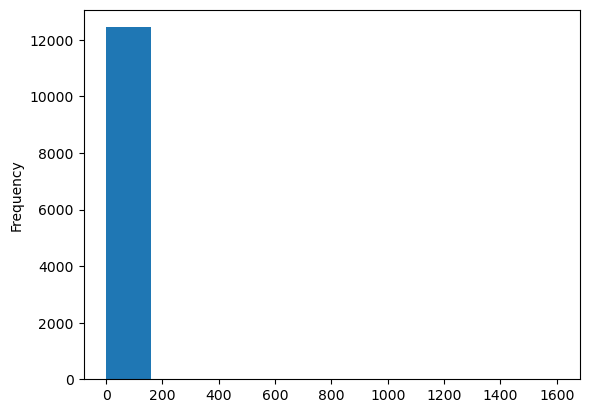

In [167]:
consumption = df['consumption'].values.tolist()

print(df)

print(f'Mean: {np.mean(consumption)}')
print(f'STD: {np.std(consumption)}')
print(f'Distribution of consumption:')
df['consumption'].plot(kind='hist')

In [168]:
df.to_csv(os.path.join(OUTPUT_DIR, country + '_lsms_clusters.csv'), index=False)